<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разбивка-на-выборки" data-toc-modified-id="Разбивка-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбивка на выборки</a></span></li><li><span><a href="#Модель-Linear-Regression" data-toc-modified-id="Модель-Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Linear Regression</a></span></li><li><span><a href="#Кросс-валидатор-временных-рядов" data-toc-modified-id="Кросс-валидатор-временных-рядов-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Кросс-валидатор временных рядов</a></span></li><li><span><a href="#Модель-Linear-Forest-Regression" data-toc-modified-id="Модель-Linear-Forest-Regression-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель Linear Forest Regression</a></span></li><li><span><a href="#Модель-Linear-Boosting-Regression" data-toc-modified-id="Модель-Linear-Boosting-Regression-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Модель Linear Boosting Regression</a></span></li><li><span><a href="#Модель-CatBoost-Regression" data-toc-modified-id="Модель-CatBoost-Regression-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Модель CatBoost Regression</a></span></li><li><span><a href="#Модель-LGBM-Regression" data-toc-modified-id="Модель-LGBM-Regression-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Модель LGBM Regression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговые выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

#  Цель исследования

Построить модель для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

#  Ход исследования

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

#  Загрузка библиотек

In [1]:
!pip install -U scikit-learn -q
!pip install phik -q
!pip install shap -q
!pip install --upgrade linear-tree -q

In [2]:
# для работы с датасетами:
import pandas as pd

# математика:
import numpy as np

# для преобразования стиля столбцов:
import re

# для работы со временем:
import time

# для работы с графиками:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import seaborn as sns
import plotly.express as px

# для подготовки данных:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
import shap

# класс для работы с пропусками:
from sklearn.impute import SimpleImputer

# нужные модели:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from lineartree import LinearForestRegressor, LinearBoostRegressor
from sklearn.dummy import DummyRegressor

# для разделения выборок:
from sklearn.model_selection import train_test_split

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

# для градиентного бустинга:
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor

# загружаем класс pipeline:
from sklearn.pipeline import Pipeline

# загружаем функции для работы с метриками
from sklearn.metrics import (
    roc_auc_score, f1_score, 
    mean_squared_error, 
    r2_score, mean_absolute_error, 
    accuracy_score, confusion_matrix, 
    recall_score, precision_score, 
    precision_recall_curve,
    make_scorer
)

# Разложение временного ряда на тренд, сезонность и остаток
from statsmodels.tsa.seasonal import seasonal_decompose

# Убираем ненужные пердупреждения:
import warnings
warnings.filterwarnings('ignore')

# для расчета коэффициентов взаимосвязи
import phik

# для определения важности признаков
import shap

In [3]:
# отображение всех колонок при выводе на печать
pd.set_option('display.max_columns', None)

In [4]:
# для настройки среды визуализации
rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'svg'
# дополнительно для графиков
factor = .8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

In [5]:
# зафиксируем константы:
RANDOM_STATE = 42
TEST_SIZE = .1

## Подготовка

In [6]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates = [0]) 
       
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates = [0])

In [7]:
# Отсортируем по индексу и проверим в хронологическом ли порядке расположены даты и время:
data = data.sort_index()
data.index.is_monotonic

True

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Выполним ресемплинг. Выберем интервал в один час, а по каждой группе — вычислим суммарное значение. Посмотрим на временной график:

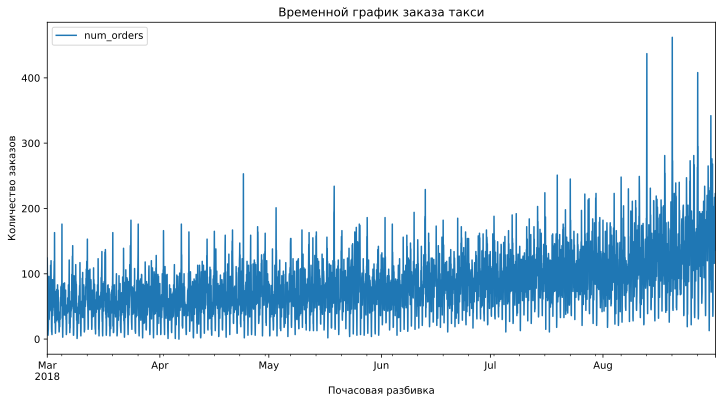

In [11]:
data = data.resample('1H').sum()
data.plot()
plt.title('Временной график заказа такси')
plt.xlabel('Почасовая разбивка')
plt.ylabel('Количество заказов');

In [12]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод по итогам загрузки и подготовки данных**
- данные файла `taxi.csv` были успешно считаны, столбец `datetime` переведне в тип данных "datetime64[ns]" и определен как индекс;
- остался один столбец с информацией - `num_orders`, в нем отсутствуют пропуски, отклонений не выявлено;
- данные были отсортированы и преобразованы во временной ряд;
- проведена проверка на монотонность временного ряда;
- выполнено ресемплирование с интервалом в один час с агрегирующией функцией значения ряда - sum();
- глядя на график, можно отметить, что рост заказов скорее всего имеет линейную зависимость и наблюдается с марта по август, более глубокий анализ рассмотрим в следущей части исследования.

## Анализ

Как видно на гарфике, временной ряд имеет множество колебаний. Чтобы снизить эти колебания, применим скользящее среднее и посмотрим вновь на график:

In [13]:
# Для анализа возьмем копию нашего ресемплированного временного ряда:
data_copy = data.copy()

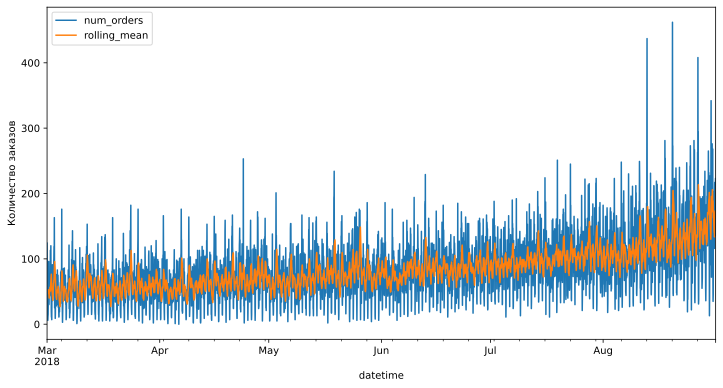

In [14]:
#data_copy['rolling_mean'] = data_copy['num_orders'].rolling(10).mean()
data_copy['rolling_mean'] = data_copy['num_orders'].rolling(10, closed='left').mean()
data_copy['num_orders'].plot()
data_copy['rolling_mean'].plot(ax=plt.gca())
plt.legend()
plt.ylabel('Количество заказов');

Ряд не стационарен, посмотрим стационарны ли разности временного ряда:

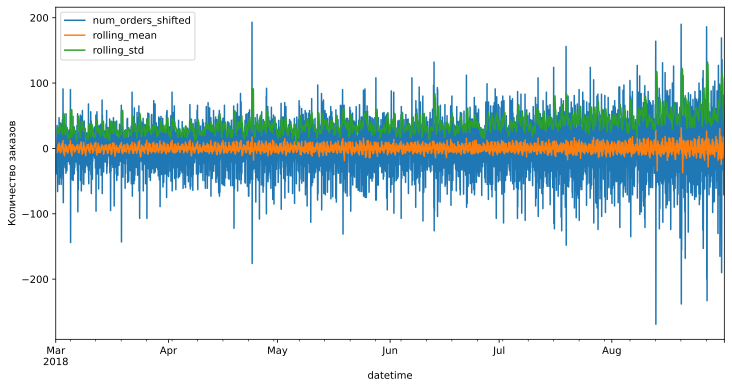

In [15]:
data_copy['num_orders_shifted'] = data_copy['num_orders'] - data_copy['num_orders'].shift()
data_copy['rolling_mean'] = data_copy['num_orders_shifted'].rolling(10).mean()
data_copy['rolling_std'] = data_copy['num_orders_shifted'].rolling(10).std()
data_copy['num_orders_shifted'].plot()
data_copy['rolling_mean'].plot(ax=plt.gca())
data_copy['rolling_std'].plot(ax=plt.gca())
plt.legend()
plt.ylabel('Количество заказов');

Ряд стал более стационарным, скользящее стандартное отклонение также не имеет аномалий.

Рассмотрим тренд и сезонность, где decomposed.trend — тренд, decomposed.seasonal — сезонная составляющая, decomposed.resid — остаток декомпозиции.

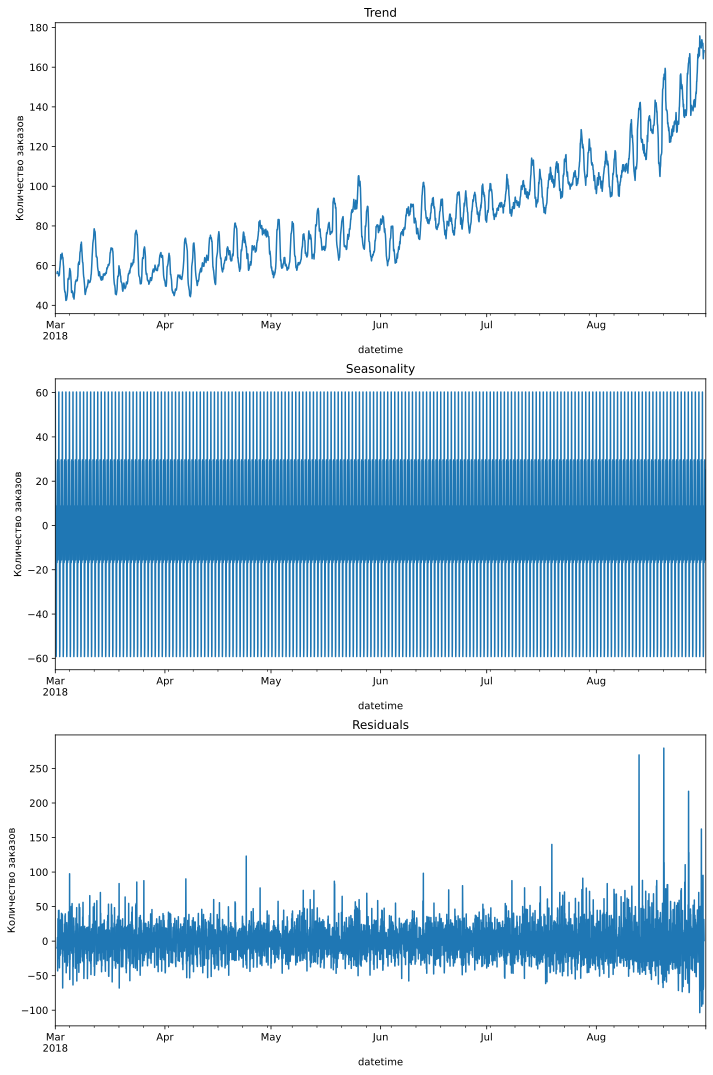

In [16]:
decomposed = seasonal_decompose(data_copy['num_orders']) 
plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Количество заказов')
plt.tight_layout()

Разложение временного ряда на составляющие, доказало наше предположение - что в данных присутствует тренд - линейное увеличение заказов на протяжении полугода, также в данных присутствует шум. Для сезонности выбран не верный машстаб.

Рассмотрим как меняется количество заказов в разрезе недели. Возьмем для примера полную первую неделю наших данных (с 05.03.2018 по 11.03.2018):

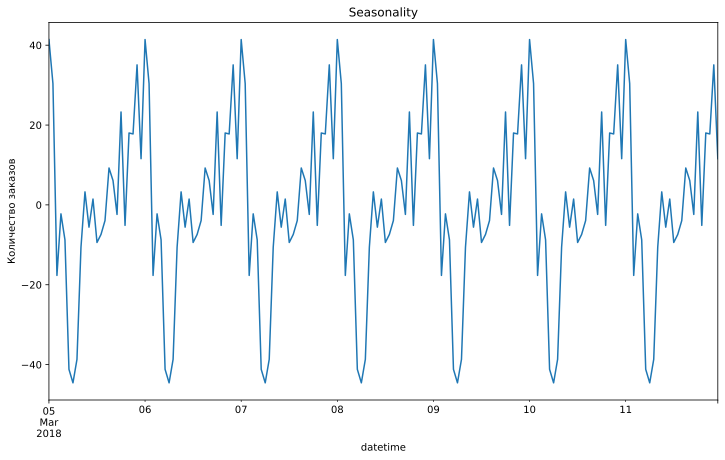

In [17]:
decomposed = seasonal_decompose(data_copy['num_orders']['2018-03-05':'2018-03-11']) 

plt.figure(figsize=(12, 15))
plt.subplot(211)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов');

Присутствуют повторяющиеся закономерности в разрезе дня - рост количества заказов происходит ежедневно в вечернее врямя. В воскресенье этот рост чуть ниже.

**Выводы по итогам анализа**

- Временной ряд имеет множественные колебания, в данных наблюдается плавное измение тренда за рассматриваемый период.
- Ряд не стационарен, однако, разности временного ряда являются стационарными.
- Разложение временного ряда на тренд, сезонность и остаток показало, линейное увеличение заказов на протяжении года - положительный тренд, также в данных присутствует шум.
- Тренд не совсем постоянный - в августе наблюдается рост по экспоненте.
- Сезонность была рассмотрена на двух временных отрезках - все данные(несколько месяцев) и на одной неделе. Анализ сезонности на всем временном отрезке ничего не показал, а вот на интревале в неделю присутствуют циклично-повторяющиеся закономерности, в данном случае  - рост количества заказов происходит ежедневно в вечернее врямя. В воскресенье этот рост чуть ниже.

## Обучение

### Создание признаков

Создадим признаки для горизонта прогнозирования в 1 шаг. Для этого напишем функцию, где учтем:
- календарные признаки - возьмем дни недели и часы (именно в этих периодах, как мы выяснили ранее, наблюдаются повторяющиеся закономерности);
- отстающие значения - предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться;
- скользящее среднее, как признак который задаёт общий тренд временного ряда

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Так как нас интересует  горизонт планирования в 1 час, а сезонность наблюдается каждые 24 часа, возьмем значение максимального запаздывание max_lag = 24 и значение окна скользящего среднего rolling_mean_size = 24:

In [19]:
make_features(data, 24, 24)

In [20]:
data.sample(5)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-12 04:00:00,30,3,4,72.0,76.0,73.0,85.0,98.0,113.0,43.0,60.0,82.0,49.0,23.0,84.0,65.0,58.0,41.0,53.0,93.0,113.0,49.0,60.0,20.0,9.0,23.0,25.0,61.125000
2018-03-04 00:00:00,75,6,0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,46.0,76.0,41.0,28.0,32.0,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,53.750000
2018-03-31 08:00:00,56,5,8,20.0,7.0,42.0,42.0,62.0,50.0,89.0,128.0,106.0,109.0,82.0,76.0,64.0,39.0,47.0,99.0,69.0,51.0,61.0,38.0,97.0,103.0,57.0,55.0,66.375000
2018-08-04 20:00:00,83,5,20,98.0,61.0,128.0,166.0,107.0,105.0,39.0,96.0,97.0,82.0,129.0,120.0,23.0,45.0,69.0,131.0,149.0,223.0,134.0,169.0,123.0,170.0,123.0,87.0,111.416667
2018-05-05 04:00:00,30,5,4,99.0,75.0,76.0,104.0,90.0,82.0,75.0,68.0,72.0,48.0,54.0,96.0,55.0,97.0,67.0,34.0,75.0,83.0,40.0,57.0,13.0,29.0,17.0,16.0,63.416667


### Разбивка на выборки

По условиям проекта необходимо сделать тестовую выборку размером 10% от исходных данных. Чтобы оценка качества модели была более надежной, подготовим, помимо тестовой выборки и валидационную. Разобьем данные на тренировочную, валидационную и тестовую выборки в соотношении 7:2:1 соответственно.

In [21]:
train, test = train_test_split(data, shuffle=False, test_size=0.3)
test, valid = train_test_split(test, shuffle=False, test_size=0.667)

Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.
Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет. В предыдущих задачах значения этих признаков были NaN. Их нужно удалить.

In [22]:
train = train.dropna()

In [23]:
train.isna().sum()

num_orders      0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

В полученных выборках выделим признаки и целевой признак:

In [24]:
train_featrues = train.drop('num_orders', axis=1)
train_target = train['num_orders']
valid_featrues = valid.drop('num_orders', axis=1)
valid_target = valid['num_orders']
test_featrues = test.drop('num_orders', axis=1)
test_target = test['num_orders']

### Модель Linear Regression

In [25]:
model_lr = LinearRegression()
start_time_lr = time.time()
model_lr.fit(train_featrues, train_target)
training_time_lr = time.time() - start_time_lr

In [26]:
# расчет RMSE на тренировочной выборке
linear_regression_train_rmse = mean_squared_error(train_target, model_lr.predict(train_featrues))**0.5
print("RMSE тренировочной выборки:", round(linear_regression_train_rmse, 2))

RMSE тренировочной выборки: 23.68


In [27]:
# расчет RMSE на валидационной выборке
linear_regression_valid_rmse = mean_squared_error(valid_target, model_lr.predict(valid_featrues))**0.5
print("RMSE валидационной выборки: ", round(linear_regression_valid_rmse, 2))

RMSE валидационной выборки:  41.04


In [28]:
# время обучения линейной регрессии:
round(training_time_lr, 3)

0.013

### Кросс-валидатор временных рядов

Кросс-валидатор временных рядов формирует число фолдов указанных в параметрах, таким образом чтобы данные были разбиты без перемешивания, а к каждому новому фолду добавляется новая единица данных (и в трейн и в тест часть). Инициализируем с n_splits=5:

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

### Модель Linear Forest Regression

In [30]:
# Зададим в качестве базового оценщика LinearRegression
model_lfr = LinearBoostRegressor(base_estimator=LinearRegression(), random_state=RANDOM_STATE)

In [31]:
model_lfr_parameters = {'n_estimators':[1, 2, 3, 4, 5], 
                        'max_depth':[3, 4, 5, 7, 15]
                       }

model_lfr_gridsearch = GridSearchCV(model_lfr, 
                                    param_grid=model_lfr_parameters, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=tscv)

In [32]:
start_time_lfr = time.time()
model_lfr_gridsearch.fit(train_featrues, train_target)
training_time_lfr = time.time() - start_time_lfr

In [33]:
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearForestRegressor(base_estimator=LinearRegression(),
                                             random_state=RANDOM_STATE),
             param_grid={'max_depth': [3, 4, 5, 7, 15],
                         'n_estimators': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearForestRegressor(base_estimator=LinearRegression(),
                                             random_state=42),
             param_grid={'max_depth': [3, 4, 5, 7, 15],
                         'n_estimators': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

In [34]:
# Посмотрим на подобранные параметры:
print("Лучшие параметры:")
model_lfr_best_parameters = model_lfr_gridsearch.best_estimator_.get_params()
for param_name in sorted(model_lfr_best_parameters.keys()):
    print("\t%s: %r" % (param_name, model_lfr_best_parameters[param_name]))

Лучшие параметры:
	base_estimator: LinearRegression()
	base_estimator__copy_X: True
	base_estimator__fit_intercept: True
	base_estimator__n_jobs: None
	base_estimator__positive: False
	ccp_alpha: 0.0
	loss: 'linear'
	max_depth: 3
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	n_estimators: 5
	random_state: 42


In [35]:
# расчет RMSE на тренировочной выборке
linear_forest_regressor_train_rmse = mean_squared_error(train_target, 
                                                        model_lfr_gridsearch.best_estimator_.predict(train_featrues))**0.5
print("RMSE тренировочной выборки:", round(linear_forest_regressor_train_rmse, 2))

RMSE тренировочной выборки: 22.27


In [36]:
# расчет RMSE на валидационной выборке
linear_forest_regressor_valid_rmse = mean_squared_error(valid_target, 
                                                        model_lfr_gridsearch.best_estimator_.predict(valid_featrues))**0.5
print("RMSE валидационной выборки:", round(linear_forest_regressor_valid_rmse, 2))

RMSE валидационной выборки: 41.64


In [37]:
# время обучения линейной регрессии:
round(training_time_lfr, 3)

9.949

### Модель Linear Boosting Regression

In [38]:
# Зададим в качестве базового оценщика LinearRegression
model_lbr = LinearBoostRegressor(base_estimator=LinearRegression(), loss='square', random_state=RANDOM_STATE)

In [39]:
model_lbr_parameters = {'n_estimators':[1, 2, 3, 4, 5], 
                        'max_depth':[3, 4, 5, 7, 15], 
                        'min_samples_split':[2, 3, 4], 
                        'min_samples_leaf':[5, 6, 7, 10, 15, 25],
                       }

model_lbr_gridsearch = GridSearchCV(model_lbr, 
                                    param_grid=model_lbr_parameters, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=tscv)

In [40]:
start_time_lbr = time.time()
model_lbr_gridsearch.fit(train_featrues, train_target)
training_time_lbr = time.time() - start_time_lbr

In [41]:
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearBoostRegressor(base_estimator=LinearRegression(),
                                            loss='square', random_state=2007),
             param_grid={'max_depth': [3, 4, 5, 7, 15],
                         'min_samples_leaf': [5, 6, 7, 10, 15, 25],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearBoostRegressor(base_estimator=LinearRegression(),
                                            loss='square', random_state=2007),
             param_grid={'max_depth': [3, 4, 5, 7, 15],
                         'min_samples_leaf': [5, 6, 7, 10, 15, 25],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

In [42]:
# Посмотрим на подобранные параметры:
print("Лучшие параметры:")
model_lbr_best_parameters = model_lbr_gridsearch.best_estimator_.get_params()
for param_name in sorted(model_lbr_best_parameters.keys()):
    print("\t%s: %r" % (param_name, model_lbr_best_parameters[param_name]))

Лучшие параметры:
	base_estimator: LinearRegression()
	base_estimator__copy_X: True
	base_estimator__fit_intercept: True
	base_estimator__n_jobs: None
	base_estimator__positive: False
	ccp_alpha: 0.0
	loss: 'square'
	max_depth: 4
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 15
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	n_estimators: 2
	random_state: 42


In [43]:
# расчет RMSE на тренировочной выборке
linear_boost_regressor_train_rmse = mean_squared_error(train_target, 
                                                       model_lbr_gridsearch.best_estimator_.predict(train_featrues))**0.5
print("RMSE тренировочной выборки:", round(linear_boost_regressor_train_rmse, 2))

RMSE тренировочной выборки: 23.3


In [44]:
# расчет RMSE на валидационной выборке
linear_boost_regressor_valid_rmse = mean_squared_error(valid_target, 
                                                        model_lbr_gridsearch.best_estimator_.predict(valid_featrues))**0.5
print("RMSE валидационной выборки:", round(linear_boost_regressor_valid_rmse, 2))

RMSE валидационной выборки: 41.02


In [45]:
# время обучения гибридной модели, состоящей из градиентного бустинга и линейной регрессии:
round(training_time_lbr, 3)

156.168

### Модель CatBoost Regression

In [46]:
# Инициализация Pool
train_pool = Pool(train_featrues, train_target)
valid_pool = Pool(valid_featrues)
test_pool = Pool(test_featrues)

In [47]:
# Инициализация модели CatBoostRegressor
model_catbr = CatBoostRegressor(logging_level='Silent', random_seed=1979, loss_function="RMSE")

In [48]:
model_catbr_grid = {'learning_rate': [0.2, 0.5], 
                          'iterations': [50,100], 
                          'depth': [5, 10], 
                          'l2_leaf_reg': [3, 9], 
                          'border_count': [125, 254]
                         }

In [49]:
start_time_catbr = time.time()
model_catbr_gridsearch = model_catbr.grid_search(model_catbr_grid, 
                                                 train_pool, 
                                                 cv=tscv, 
                                                 partition_random_seed=0, 
                                                 calc_cv_statistics=True, 
                                                 search_by_train_test_split=True, 
                                                 shuffle=False, 
                                                 train_size=0.8, 
                                                 verbose=False, 
                                                 plot=True)
training_time_catbr = time.time() - start_time_catbr

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [50]:
model_catbr_all_params = model_catbr.get_all_params()
print('iterations:', model_catbr_all_params['iterations'])
print('depth:', model_catbr_all_params['depth'])
print('learning_rate:',model_catbr_all_params['learning_rate'])
print('l2_leaf_reg:', model_catbr_all_params['l2_leaf_reg'])
print('border_count:', model_catbr_all_params['border_count'])

iterations: 100
depth: 5
learning_rate: 0.20000000298023224
l2_leaf_reg: 9
border_count: 125


In [51]:
# расчет RMSE на тренировочной выборке
cat_boost_regressor_train_rmse = mean_squared_error(train_target, 
                                                       model_catbr.predict(train_pool))**0.5
print("RMSE тренировочной выборки:", round(cat_boost_regressor_train_rmse, 2))

RMSE тренировочной выборки: 16.28


In [52]:
# расчет RMSE на валидационной выборке
cat_boost_regressor_valid_rmse = mean_squared_error(valid_target, 
                                                        model_catbr.predict(valid_pool))**0.5
print("RMSE валидационной выборки:", round(cat_boost_regressor_valid_rmse, 2))

RMSE валидационной выборки: 48.83


In [53]:
# время обучения CatBoostRegressor:
round(training_time_catbr, 3)

55.908

### Модель LGBM Regression

In [54]:
model_lgbmr = LGBMRegressor(random_state=RANDOM_STATE)

In [55]:
model_lgbmr_parameters = {'n_estimators': [50, 100, 200], 
                          'max_depth': [3, 5, 7]}
model_lgbmr_grid = GridSearchCV(model_lgbmr, 
                                model_lgbmr_parameters, 
                                n_jobs=-1, 
                                cv=tscv, 
                                scoring='neg_root_mean_squared_error')

In [56]:
start_time_lgbmr = time.time()
model_lgbmr_grid.fit(train_featrues, train_target)
training_time_model_lgbmr_grid = time.time() - start_time_lgbmr

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4288
[LightGBM] [Info] Number of data points in the train set: 3067, number of used features: 27
[LightGBM] [Info] Start training from score 70.742419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [57]:
# расчет RMSE на тренировочной выборке
model_lgbmr_train_rmse = mean_squared_error(train_target, 
                                                       model_lgbmr_grid.predict(train_featrues))**0.5
print("RMSE тренировочной выборки:", round(model_lgbmr_train_rmse, 2))

RMSE тренировочной выборки: 18.02


In [58]:
# расчет RMSE на валидационной выборке
model_lgbmr_valid_rmse = mean_squared_error(valid_target, 
                                                        model_lgbmr_grid.predict(valid_featrues))**0.5
print("RMSE валидационной выборки:", round(model_lgbmr_valid_rmse, 2))

RMSE валидационной выборки: 46.87


In [59]:
# время обучения LGBMRegressor:
round(training_time_model_lgbmr_grid, 3)

8.039

## Тестирование

Сведем все полученные данные моделей в таблицу:

In [60]:
results = pd.DataFrame({'RMSE_train':[round(linear_regression_train_rmse, 2), 
                                      round(linear_forest_regressor_train_rmse, 2), 
                                      round(linear_boost_regressor_train_rmse, 2), 
                                      round(cat_boost_regressor_train_rmse, 2), 
                                      round(model_lgbmr_train_rmse, 2)], 
                        'RMSE_valid':[round(linear_regression_valid_rmse, 2), 
                                      round(linear_forest_regressor_valid_rmse, 2), 
                                      round(linear_boost_regressor_valid_rmse, 2), 
                                      round(cat_boost_regressor_valid_rmse, 2), 
                                      round(model_lgbmr_valid_rmse, 2)],
                        'Time_predict':[round(training_time_lr, 3), 
                                        round(training_time_lfr, 3), 
                                        round(training_time_lbr, 3), 
                                        round(training_time_catbr, 3), 
                                        round(training_time_model_lgbmr_grid, 3)]
                       }, 
                       index=['Linear Regression', 
                              'Linear Forest Regression', 
                              'Linear Boosting Regression', 
                              'CatBoost Regression', 
                              'LGBM Regression'])
results.sort_values(by=['RMSE_valid'])

,RMSE_train,RMSE_valid,Time_predict
Linear Boosting Regression,23.30,41.02,156.168
Linear Regression,23.68,41.04,0.013
Linear Forest Regression,22.27,41.64,9.949
LGBM Regression,18.02,46.87,8.039
CatBoost Regression,16.28,48.83,55.908


Самой точной моделью, с минимальной RSME на валидационной выборке, в нашем исследовании получилась Linear Boosting Regression, не смотря на самое долгое время обучения.

Рассмотрим результат метрики на тестовой выборке:

In [61]:
linear_boost_regressor_test_rmse = mean_squared_error(test_target, 
                                                        model_lbr_gridsearch.best_estimator_.predict(test_featrues))**0.5
print("RMSE тестовой выборки:", round(linear_boost_regressor_test_rmse, 2))

RMSE тестовой выборки: 30.72


## Итоговые выводы

**Целью данного проекта было построение модель для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки, при этом значение метрики *RMSE* на тестовой выборке должно быть не больше 48**

**Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).**

**Вывод по итогам загрузки и подготовки данных**
- данные файла `taxi.csv` были успешно считаны, столбец `datetime` переведне в тип данных "datetime64[ns]" и определен как индекс;
- остался один столбец с информацией - `num_orders`, в нем отсутствуют пропуски, отклонений не выявлено;
- данные были отсортированы и преобразованы во временной ряд;
- проведена проверка на монотонность временного ряда;
- выполнено ресемплирование с интервалом в один час с агрегирующией функцией значения ряда - sum();
- глядя на график, можно отметить, что рост заказов скорее всего имеет линейную зависимость и наблюдается с марта по август, более глубокий анализ рассмотрим в следущей части исследования.

**Выводы по итогам анализа**
- Временной ряд имеет множественные колебания, в данных наблюдается плавное измение тренда за рассматриваемый период.
- Ряд не стационарен, однако, разности временного ряда являются стационарными.
- Разложение временного ряда на тренд, сезонность и остаток показало, линейное увеличение заказов на протяжении года - положительный тренд, также в данных присутствует шум. 
- Сезонность была рассмотрена на двух временных отрезках - все данные(несколько месяцев) и на одной неделе. Анализ сезонности на всем временном отрезке ничего не показал, а вот на интревале в неделю присутствуют циклично-повторяющиеся закономерности, в данном случае  - рост количества заказов происходит ежедневно в вечернее врямя. В воскресенье этот рост чуть ниже.

**Выводы по итогам обучения**
- Подготовленный временной ряд был разложен на обучающую, валидационную и тестовую выборки в соотношении 7:2:1
- Было полготовлено и обучено 5 моделей:
    - Linear Regression;
    - Linear Forest Regression;
    - Linear Boos Regression;
    - CatBoost Regression;
    - LGBM Regression.
- Самой точной моделью, с минимальной RSME на валидационной выборке, в нашем исследовании получилась Linear Boosting Regression, не смотря на самое долгое время обучения.

**Выводы по итогам тестирования**
- На основе результатов обученных моделей временного ряда была составлена таблица с рейтингом точности по метрике RMSE на обучающих и валидационных данных. По которой была выбрана лучшая модель - Linear Boosting Regression. 
- Результат предсказания на тестовой выборке Linear Boosting Regression составил 30,73


💡 **На основе этих фактов и анализа результатов, можно сделать вывод, что заказчику лучше всего подойдет Linear Boosting Regression.**

В целом, основная цель проекта достигнута:

✔️ **Была разаработана модель машинного обучения, которая прогнозирует количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки, при этом значение метрики *RMSE* на тестовой выборке не превысило 48**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48